In [1]:
import pandas as pd
import numpy as np
import random
import json
import pickle
from os import path, makedirs

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import clone
from scipy import sparse

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from nbsvm import NBSVMClassifier

In [2]:
# Pretty print JSON objects
def pretty_print(data_dict):
    try:
        print(json.dumps(data_dict, indent=4))
    except TypeError:
        print(data_dict)
    except Exception as e:
        print(str(e))

# Create all required folder paths (recursively)
def create_paths(path_list):
    print('Creating all folder paths... ', end='', flush=True)
    for folder_path in path_list:
        if not path.exists(folder_path):
            makedirs(folder_path)
    print('Done.')

# Dump data to disk if not present
def dump_data(data, name, file_path, force=False):
    if force or not path.isfile(file_path):
        print('Dumping {}... '.format(name), end='', flush=True)
        pickle.dump(data, open(file_path, 'wb'))
        print('Done.')
    else:
        print('Did not dump {}: File already exists in "{}".'.format(name, file_path))

# Load all data sets
def load_data(data_cols, data_path='../data/', clean='_clean', os=''):
    print('Loading data... ', end='', flush=True)
    data_sets = {}
    
    for col in data_cols:
        data_sets[col] = pickle.load(open(data_path+'{}.pkl'.format(col),'rb'))

    print('Done.')
    return data_sets

# Load all ngrams data if present, otherwise fit on data and dump them
def load_ngrams(data_sets, data_col, num_feats, ngrams, vectorizers, pickle_path='../pickle_objects/', clean='_clean', os=''):
    data_col += clean+os
    ngrams_data = {}
    ngram_range = list(map(lambda x: x+1,range(ngrams)))
    vec_params = {'analyzer': 'word', 'lowercase': True,'max_features': num_feats, 'ngram_range': ngram_range}
    
    for vec in vectorizers:
        # Load vectorizer if present
        file_name = '{}{}_ngrams_{}_{}_{}.pkl'.format(pickle_path, vec, data_col, num_feats, ngrams)
        if path.isfile(file_name):
            print('Loading {} ngrams... '.format(vec), end='', flush=True)
            ngrams_data[vec] = pickle.load(open(file_name, 'rb'))
            print('Done.')
        else:
            # Fit, store, and load vectorizer
            print('{} ngrams not found. Fitting them... '.format(vec), end='', flush=True)
            ngrams_vec = CountVectorizer(**vec_params) if vec == 'countvec' else TfidfVectorizer(**vec_params)
            ngrams_vec.fit(data_sets[data_col]['comment_text'])
            ngrams_data[vec] = ngrams_vec
            dump_data(ngrams_vec, '{} ngrams'.format(vec), file_name)
    return ngrams_data

# Transform data on fitted ngrams data
def transform_to_ngrams(data_sets, data_cols, ngrams_data, vectorizers):
    print('Transforming data to ngrams... ', end='', flush=True)
    for data in data_cols:
        for vec in vectorizers:
            data_sets[data+'_'+vec] = ngrams_data[vec].transform(data_sets[data]['comment_text'])
    print('Done.')
    return data_sets

# Extract features and to data
def generate_features(data_sets, data_cols, vectorizers):
    print('Extracting features from data...')

    # Get all data sets with features
    X_cols = [col for col in data_cols if 'X' in col]
    
    # Add features
    for col in X_cols:
        for vec in vectorizers:
            # Comment Text Length
            print("\tGenerating 'comment_length' for {}_{}... ".format(col, vec), end='', flush=True)
            data_sets[col+'_'+vec+features] = np.hstack((data_sets[col+'_'+vec].todense(), \
                                                data_sets[col]['comment_text'].str.len().values.reshape(-1,1)))
            print('Done.')

            # Standard Deviation of Word Length in Comment Text
            print("\tGenerating 'word_length_std' for {}_{}... ".format(col, vec), end='', flush=True)
            stddevs = np.array([])
            for row in data_sets[col]['comment_text'].str.split().iteritems():
                value = np.std([len(word) for word in row[1]]) if len(row[1]) else 0.
                stddevs = np.append(stddevs, value)
            print('Done.')
            data_sets[col+'_'+vec+features] = np.hstack((data_sets[col+'_'+vec+features], stddevs.reshape(-1,1)))
            
            print('Converting back to sparse matrix... ', end='', flush=True)
            data_sets[col+'_'+vec+features] = sparse.csr_matrix(data_sets[col+'_'+vec+features])
            print('Done.')

    print('Done.')

    return data_sets

# Dump all models of a type fitted on all target columns
def dump_models(model, X, model_name, target_cols, model_path='../pickle_objects/models/', force=False):
    for target in target_cols:
        file_name = '{}{}_{}_{}.pkl'.format(model_path, model_name, X, target)
        if force or not path.isfile(file_name):
            print('\t\tDumping {} fitted on {}... '.format(model_name, target), end='', flush=True)
            pickle.dump(model[target], open(file_name, 'wb'))
            print('Done.')
        else:
            print('\t\tDid not dump {} fitted on {}: File already exists in "{}".' \
                  .format(model_name, target, file_name))

# Fit a model on all target columns after performing grid search or with best parameters
def fit_model(base_model, X, y, param_grid, target_cols, scoring='roc_auc', cv=None):
    if cv:
        models, mean_val_scores, params = {}, [], []
        for target in target_cols:
            print('\t\tRunning for {}... '.format(target), end='', flush=True)
            model_target = GridSearchCV(base_model, param_grid, cv=cv, scoring=scoring, n_jobs=4, refit=False)
            model_target.fit(X, y[target])
            print('Done.')
            mean_val_scores.append(model_target.cv_results_['mean_test_score'])
            if not params:
                params = model_target.cv_results_['params']
        mean_val_scores = np.mean(np.array(mean_val_scores), axis=0)
        best_param_idx = np.argmax(mean_val_scores)
        models['best_params_'], models['best_mean_score_'] = \
        params[best_param_idx], mean_val_scores[best_param_idx]
    else:
        models = {}
        for target in target_cols:
            model = clone(base_model)
            print('\t\tRunning for {}... '.format(target), end='', flush=True)
            model.set_params(**param_grid).fit(X, y[target])
            models[target] = model
            print('Done.')
    return models

# Fit all models on all target columns or dump the refitted ones with best parameters
def fit_all_models(data_sets, data_cols, model_list, param_grids, target_cols, \
                   model_path='../pickle_path/models/', cv=None):
    best_models, best_params, best_scores = {}, {}, {}
    X, y = data_cols
    for model in model_list:
        print('\tRunning {}...'.format(model))
        best_models[model] = fit_model(model_list[model], data_sets[X], data_sets[y], \
                                       param_grids[model], target_cols, 'roc_auc', cv)
        print('\tDone.')
        if cv:
            pretty_print(best_models[model])
        else:
            print('\tDumping {}... '.format(model))
            dump_models(best_models[model], X, model, target_cols, model_path)
            print('\tDone.')
    return best_models

# Refit all models on all target columns with best parameters
def refit_best_models(data_sets, model_list, data_cols, best_models, \
                      target_cols, model_path='../pickle_path/models/'):
    # Refit all models with all data sets with best hyperparameters
    print('Refitting with best parameters...')
    best_params = {}
    for model in model_list:
        best_params[model] = best_models[model]['best_params_']
    best_refitted_models = fit_all_models(data_sets, data_cols, model_list, best_params, \
                                          target_cols, model_path, cv=None)
    print('Done.')
    return best_refitted_models

# Load all models of a type fitted on all target columns
def load_models(model_name, X, target_cols, model_path='../pickle_objects/models/'):
    model = {}
    for target in target_cols:
        file_name = '{}{}_{}_{}.pkl'.format(model_path, model_name, X, target)
        if path.isfile(file_name):
            print('\tLoading {} fitted on {}... '.format(model_name, target), end='', flush=True)
            model[target] = pickle.load(open(file_name, 'rb'))
            print('Done.')
        else:
            print('\tDid not load {} fitted on {}: File not found in "{}".' \
                  .format(model_name, target, file_name))
    return model

# Load all models fitted on all target columns
def load_all_models(model_list, data_cols, target_cols, model_path='../pickle_path/models/'):
    print('Loading models fitted with best parameters...')
    best_models = {}
    X, y = data_cols
    for model_name in model_list:
        best_models[model_name] = load_models(model_name, X, target_cols, model_path)
    print('Done.')
    return best_models

# Predict labels and probabilities for all models for all target columns
def predict_labels_and_probas(fitted_models, model_list, X, target_cols):
    probabilities, predictions = {}, {}
    for model in model_list:
        print('\tPredicting labels and probabilities for {}...'.format(model))
        probabilities[model], predictions[model] = {}, {}
        for target in target_cols:
            print('\t\tPredicting for {}... '.format(target), end='', flush=True)
            probabilities[model][target] = fitted_models[model][target].predict_proba(X)[:,1]
            predictions[model][target] = fitted_models[model][target].predict(X)
            print('Done.')
        print('\tDone.')
    return probabilities, predictions

# Plot ROC curves for all models / target columns
def plot_model_roc_curves(y_test, probabilities, model_list, target_cols, vec='countvec', \
                          plot_type='model', features='_features', plots_path='../plots/', force=False):
    aucs = {}
    # Plot by model
    if plot_type == 'model':
        for model in model_list:
            print('\tPlotting ROC curve for {}...'.format(model))
            aucs[model] = {}
            plt.figure(figsize=(5,4))
            for target in target_cols:
                fpr, tpr, threshold = roc_curve(y_test[target], probabilities[model][target])
                auc_value = auc(fpr, tpr)
                aucs[model][target] = auc_value
                plt.plot(fpr, tpr, label='{}: {:0.3f}'.format('auc{}_'.format(features)+target, auc_value))
            plt.xlabel('fpr')
            plt.ylabel('tpr')
            plt.title('ROC Curve for {}{} with {}'.format(model, features, vec))
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.legend(loc=4)
            file_path = plots_path+'roc_'+model+'_'+vec+features+'.jpg'
            if force or not path.isfile(file_path):
                print('\tDumping ROC plot to {}... '.format(file_path), end='', flush=True)
                plt.savefig(file_path)
                print('Done.')
            else:
                print('\tDid not dump ROC plot: File already exists in "{}".'.format(file_path))
            plt.close('all')
            print('\tDone.')
    # Plot by target column
    elif plot_type == 'target':
        for target in target_cols:
            print('\tPlotting ROC curve for {}...'.format(target))
            aucs[target] = {}
            plt.figure(figsize=(5,4))
            for model in model_list:
                fpr, tpr, threshold = roc_curve(y_test[target], probabilities[model][target])
                auc_value = auc(fpr, tpr)
                aucs[target][model] = auc_value
                plt.plot(fpr, tpr, label='{}: {:0.3f}'.format('auc{}_'.format(features)+model, auc_value))
            plt.xlabel('fpr')
            plt.ylabel('tpr')
            plt.title('ROC Curve for {}{} with {}'.format(target, features, vec))
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.legend(loc=4)
            file_path = plots_path+'roc_'+target+'_'+vec+features+'.jpg'
            if force or not path.isfile(file_path):
                print('\tDumping ROC plot to {}... '.format(file_path), end='', flush=True)
                plt.savefig(file_path)
                print('\tDone.')
            else:
                print('\tDid not dump ROC plot: File already exists in "{}".'.format(file_path))
            plt.close('all')
            print('\tDone.')
    else:
        raise ValueError("Parameter 'plot_type' must be one of 'model' or 'target'.")
    return aucs

# Generate mean column-wise AUC for all models
def get_mean_auc(aucs, model_list=None, target_cols=None, plot_type='model'):
    print('\tComputing mean AUCs... ', end='', flush=True)
    mean_aucs = {}
    # Compute mean auc by model
    columns = model_list if plot_type == 'model' else target_cols
    for col in columns:
        mean_aucs[col] = np.mean(list(aucs[col].values()))
    print('Done.')
    return mean_aucs

# Generate a summary AUCs dataframe for all models vs. all target columns
def get_aucs_df(aucs, model_list, target_cols, plot_type='model'):
    print('\tGenerating AUCs DataFrame... ', end='', flush=True)
    aucs_df = pd.DataFrame.from_dict(aucs)
    aucs_df['mean'] = np.mean(aucs_df, axis=1)
    aucs_df.loc['mean'] = np.mean(aucs_df, axis=0)
    print('Done.')
    return aucs_df

# Plot all ROC curves, dump all mean column-wise AUCs, generate summary AUCs dataframe, and return final predictions
def plot_and_dump_results(data_sets, best_refitted_models, model_list, vec, target_cols, plot_type='model', clean='_clean', \
                          os='', features='_features', plots_path='../plots/', pickle_path='../pickle_objects/', force=False):

    probabilities, predictions = predict_labels_and_probas(best_refitted_models[vec], model_list, \
                                                           data_sets['X_test'+clean+os+'_'+vec+features], target_cols)
    
    aucs = plot_model_roc_curves(data_sets['y_test'+clean+os], probabilities, model_list, \
                                 target_cols, vec, plot_type, features, plots_path, force)

    pretty_print(aucs)

    mean_aucs = get_mean_auc(aucs, model_list, target_cols, plot_type)

    pretty_print(mean_aucs)

    aucs_df = get_aucs_df(aucs, model_list, target_cols, plot_type)
    
    print('\tAUCs DataFrame for {}:'.format(vec))
    print(aucs_df)

    print('\t', end='', flush=True)
    dump_data(aucs_df, 'AUCs DataFrame', '{}aucs_{}{}.pkl'.format(pickle_path, vec, features), force)

    if plot_type == 'model':
        return probabilities, predictions

In [3]:
# Set random seed
random.seed(1337)

# Specify whether to use cleaned data or not
is_clean, is_os = 1, 0
clean = '_clean' if is_clean else ''
os = '_os' if is_os else ''

# Specify whether to use additional features
use_features = 1
features = '_features' if use_features else ''

# Set all folder paths
data_path = '../data/'
pickle_path = '../pickle_objects/'
model_path = pickle_path + 'models{}/'.format(features)
plots_path = '../plots{}/'.format(features)

# Specify initial variables
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
vectorizers = ['countvec', 'tfidf']
plot_types = ['model', 'target']
data_cols = ['data', 'X_train', 'X_val', 'X_train_val', 'X_test', 'y_train', 'y_val', 'y_train_val', 'y_test']
for i, col in enumerate(data_cols):
    data_cols[i] = col + clean + os

create_paths([data_path, pickle_path, plots_path])

Creating all folder paths... Done.


In [4]:
# Load all data sets
data_sets = load_data(data_cols, data_path, clean=clean, os=os)

Loading data... Done.


In [5]:
data_sets['data_clean']['comment_length'] = data_sets['data_clean']['comment_text'].str.len()

In [6]:
data_sets['data_clean'][['comment_length']].describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
comment_length,159571,227,361,0,54,116,245,6471


In [7]:
# List all models to be run
model_list = {
    'bnb': BernoulliNB(),
    'lrl1': LogisticRegression(penalty='l1'),
    'lrl2': LogisticRegression(penalty='l2'),
    'nbsvm': NBSVMClassifier(dual=True),
    'rf': RandomForestClassifier(),
    'xgb': XGBClassifier()
}

In [20]:
# # Refit all models with best parameters on ngrams fitted on X_train_val (+clean+os)
# best_refitted_models = {}
# for vec in vectorizers:
#     print('\nRunning for {}...'.format(vec))
#     data_cols = ('X_train_val'+clean+os+'_'+vec+features, 'y_train_val'+clean+os)
#     # Load models if already fitted and dumped
#     best_refitted_models[vec] = load_all_models(model_list, data_cols, target_cols, model_path)
#     print('\n')

In [21]:
# for target in target_cols:
#     importances = best_refitted_models['tfidf']['xgb'][target].feature_importances_
#     indices = np.argsort(importances)[::-1]
#     print('comment_length', importances[-2], )
#     print('stddev(word_length)', importances[-1])

In [22]:
# indices

In [23]:
# labels = ['comment_length', 'word_length_std']
# labels.extend(['']*len(indices[2:]))

In [24]:
# importances = best_refitted_models['tfidf']['xgb']['toxic'].feature_importances_
# indices = np.argsort(importances)[::-1]
# # Plot the feature importances of the tree
# plt.figure(figsize=(7,4))
# plt.bar(range(len(indices)), importances[indices], color="r", align="center")
# plt.title("XGBoost Feature Importance Bar Plot for 'toxic' with TfIdfVectorizer")
# plt.xlabel('Feature Name')
# plt.ylabel('Feature Importance')
# plt.xticks(range(len(indices)), labels, rotation=35, horizontalalignment='right')
# plt.xlim([-1, 20])
# plt.tight_layout()
# plt.savefig('feature_importance.jpg')
# plt.show()

In [9]:
probabilities = pickle.load(open('../pickle_objects/probabilities{}.pkl'.format(features), 'rb'))
predictions = pickle.load(open('../pickle_objects/predictions{}.pkl'.format(features), 'rb'))

In [12]:
data_sets['X_test_clean']['comment_length'] = data_sets['X_test_clean']['comment_text'].str.len()

In [14]:
data_sets['X_test_clean'].head()

,id,comment_text,comment_length
43797,74e4b95b9cb9834a,attack 98 .. begin not stop sock puppet proxy ...,155
148898,53cb4186efea9ee2,wild goose remove phrase derive ancient irish ...,199
89968,f0b3496b164a5c17,summary agree wikipedia article picture prefer...,868
143624,004a6e2dde1f82eb,-pron- like opportunity remind -pron- no long ...,293
33692,59db79e849a4cfd8,hey right thing shorten european commission lo...,171


In [15]:
# aucs_countvec = pickle.load(open('../pickle_objects/aucs_countvec.pkl', 'rb'))
# aucs_countvec_features = pickle.load(open('../pickle_objects/aucs_countvec_features.pkl', 'rb'))
# aucs_tfidf = pickle.load(open('../pickle_objects/aucs_tfidf.pkl', 'rb'))
# aucs_tfidf_features = pickle.load(open('../pickle_objects/aucs_tfidf_features.pkl', 'rb'))

In [16]:
# np.round(aucs_countvec_features, 3)

In [17]:
# np.round(aucs_countvec, 3)

In [18]:
# np.round(aucs_tfidf, 3)

In [19]:
# np.round(aucs_tfidf_features, 3)

In [25]:
data_sets['X_test_clean'].describe().T

,count,mean,std,min,25%,50%,75%,max
comment_length,31915.0,226.770421,359.842055,0.0,54.0,116.0,245.0,4999.0


In [145]:
target = 'insult'

In [146]:
data = pd.concat((data_sets['X_test_clean'], data_sets['y_test_clean'][target]), axis=1)
data.head()

,id,comment_text,comment_length,insult
43797,74e4b95b9cb9834a,attack 98 .. begin not stop sock puppet proxy ...,155,0
148898,53cb4186efea9ee2,wild goose remove phrase derive ancient irish ...,199,0
89968,f0b3496b164a5c17,summary agree wikipedia article picture prefer...,868,0
143624,004a6e2dde1f82eb,-pron- like opportunity remind -pron- no long ...,293,0
33692,59db79e849a4cfd8,hey right thing shorten european commission lo...,171,0


In [147]:
probs = pd.DataFrame(probabilities['tfidf']['lrl2'][target], columns = [target+'_prob'])

In [148]:
probs.head()

,insult_prob
0,0.041605
1,0.022156
2,0.009205
3,0.055766
4,0.014450


In [149]:
preds = pd.DataFrame(predictions['tfidf']['lrl2'][target], columns = [target+'_pred'])

In [150]:
preds.head()

,insult_pred
0,0
1,0
2,0
3,0
4,0


In [151]:
data.head()

,id,comment_text,comment_length,insult
43797,74e4b95b9cb9834a,attack 98 .. begin not stop sock puppet proxy ...,155,0
148898,53cb4186efea9ee2,wild goose remove phrase derive ancient irish ...,199,0
89968,f0b3496b164a5c17,summary agree wikipedia article picture prefer...,868,0
143624,004a6e2dde1f82eb,-pron- like opportunity remind -pron- no long ...,293,0
33692,59db79e849a4cfd8,hey right thing shorten european commission lo...,171,0


In [152]:
probs.index = data.index
preds.index = data.index

In [153]:
data = pd.concat((data, probs, preds), axis=1)
data.head()

,id,comment_text,comment_length,insult,insult_prob,insult_pred
43797,74e4b95b9cb9834a,attack 98 .. begin not stop sock puppet proxy ...,155,0,0.041605,0
148898,53cb4186efea9ee2,wild goose remove phrase derive ancient irish ...,199,0,0.022156,0
89968,f0b3496b164a5c17,summary agree wikipedia article picture prefer...,868,0,0.009205,0
143624,004a6e2dde1f82eb,-pron- like opportunity remind -pron- no long ...,293,0,0.055766,0
33692,59db79e849a4cfd8,hey right thing shorten european commission lo...,171,0,0.014450,0


In [154]:
data[(data['comment_length'] > 3000) & (data[target] != data[target+'_pred'])]

,id,comment_text,comment_length,insult,insult_prob,insult_pred
57594,9a176c24d63a5c60,supertr0ll live forever don't respect supertr0...,3415,1,0.204417,0
140930,f22cd3ccf2ae12b1,repeat daedalus969 biznitch repeat daedalus969...,3559,1,0.048239,0
140590,f052b5fb53d79e12,bad admin- bad admin- bad admin- bad admin- ba...,3171,1,0.078842,0
27045,479826ff5d74ab46,hanibal911you're bastard pro assad hanibal911y...,3709,1,0.081724,0
60802,a2c45136daf70279,fuck wikipedia fuck wikipedia fuck wikipedia f...,3119,0,0.917603,1
79419,d485121984ec3d6d,fucking libtard coward reverts factual evidenc...,3447,1,0.072871,0
53583,8f449b8ab17e2f39,prick fire administrator prick fire administra...,3451,1,0.053915,0
96267,02dd3c9a9129c83e,bootstoots friggen gayfag lolooolbootstoots fr...,3871,1,0.079336,0


In [155]:
data[target+'_indicator'] = (data[target] != data[target+'_pred'])*1

In [156]:
mean = np.mean(data['comment_length'])
median = np.median(data['comment_length'])
std = np.std(data['comment_length'])
mean, median, std

(226.77042143192855, 116.0, 359.83641751775787)

In [157]:
indices = np.argsort(data['comment_length'])

In [167]:
data.iloc[indices[:500]][(data[target] != data[target+'_pred'])].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(16, 7)

In [168]:
data.iloc[indices[-500:]][(data[target] != data['insult_pred'])].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(18, 7)

In [160]:
data[(data['comment_length'] > median + 3*std) & (data[target] != data[target+'_pred'])].shape

(23, 7)

In [161]:
data[(data['comment_length'] < median) & (data[target] != data[target+'_pred'])].shape

(662, 7)

In [162]:
data.head()

,id,comment_text,comment_length,insult,insult_prob,insult_pred,insult_indicator
43797,74e4b95b9cb9834a,attack 98 .. begin not stop sock puppet proxy ...,155,0,0.041605,0,0
148898,53cb4186efea9ee2,wild goose remove phrase derive ancient irish ...,199,0,0.022156,0,0
89968,f0b3496b164a5c17,summary agree wikipedia article picture prefer...,868,0,0.009205,0,0
143624,004a6e2dde1f82eb,-pron- like opportunity remind -pron- no long ...,293,0,0.055766,0,0
33692,59db79e849a4cfd8,hey right thing shorten european commission lo...,171,0,0.014450,0,0


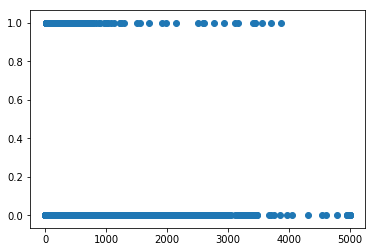

In [170]:
plt.scatter(data['comment_length'], data[target+'_indicator'])

In [171]:
incorrect_indices = data[data[target+'_indicator'] == 1].index.values

In [172]:
incorrect_indices

array([ 44214, 140483, 109790, ...,  65165,  88450,   7169])

(array([554., 211.,  99.,  53.,  33.,  24.,   8.,  11.,   5.,   7.,   2.,
          2.,   2.,   3.,   1.,   3.,   1.,   0.,   0.,   1.,   1.,   0.,
          1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          2.,   0.,   1.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,
          3.,   1.,   0.,   1.,   0.,   1.]),
 array([   4.  ,   81.34,  158.68,  236.02,  313.36,  390.7 ,  468.04,
         545.38,  622.72,  700.06,  777.4 ,  854.74,  932.08, 1009.42,
        1086.76, 1164.1 , 1241.44, 1318.78, 1396.12, 1473.46, 1550.8 ,
        1628.14, 1705.48, 1782.82, 1860.16, 1937.5 , 2014.84, 2092.18,
        2169.52, 2246.86, 2324.2 , 2401.54, 2478.88, 2556.22, 2633.56,
        2710.9 , 2788.24, 2865.58, 2942.92, 3020.26, 3097.6 , 3174.94,
        3252.28, 3329.62, 3406.96, 3484.3 , 3561.64, 3638.98, 3716.32,
        3793.66, 3871.  ]),
 <a list of 50 Patch objects>)

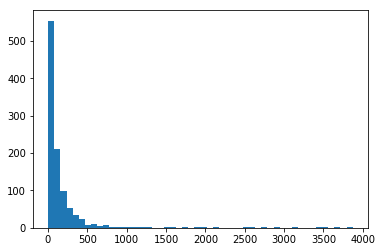

In [179]:
plt.hist(data['comment_length'][incorrect_indices], bins=50)